In [4]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm


pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_key_collector import keys_df, symbol
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()
keys_df

,contract_key,raw_data_key,surface_key,calibration_key,priced_securities_key,date
0,/date_2024_10_11/hottest_contracts,/date_2024_10_11/raw_data,/date_2024_10_11/surface,/date_2024_10_11/calibration,NaN,2024-10-11
1,/date_2024_10_10/hottest_contracts,/date_2024_10_10/raw_data,/date_2024_10_10/surface,/date_2024_10_10/calibration,NaN,2024-10-10
2,/date_2024_10_09/hottest_contracts,/date_2024_10_09/raw_data,/date_2024_10_09/surface,/date_2024_10_09/calibration,NaN,2024-10-09
3,/date_2024_10_08/hottest_contracts,/date_2024_10_08/raw_data,/date_2024_10_08/surface,/date_2024_10_08/calibration,NaN,2024-10-08
4,/date_2024_10_07/hottest_contracts,/date_2024_10_07/raw_data,/date_2024_10_07/surface,/date_2024_10_07/calibration,NaN,2024-10-07
...,...,...,...,...,...,...
794,/date_2021_08_16/hottest_contracts,/date_2021_08_16/raw_data,/date_2021_08_16/surface,NaN,NaN,2021-08-16
795,/date_2021_08_13/hottest_contracts,/date_2021_08_13/raw_data,/date_2021_08_13/surface,NaN,NaN,2021-08-13
796,/date_2021_08_12/hottest_contracts,/date_2021_08_12/raw_data,/date_2021_08_12/surface,NaN,NaN,2021-08-12
797,/date_2021_08_11/hottest_contracts,/date_2021_08_11/raw_data,/date_2021_08_11/surface,NaN,NaN,2021-08-11


# historical time-series

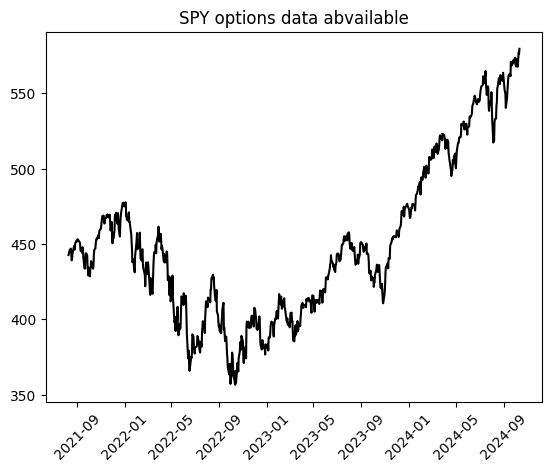

<Figure size 640x480 with 0 Axes>

In [5]:
contract_keys = keys_df.copy().dropna(subset='contract_key')
contracts = []
while True:
    try:
        store.open()
        for i,row in contract_keys.iterrows():
            contracts.append(store[row['contract_key']])
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()
contracts = pd.concat(contracts,ignore_index=True)[['date','spot_price']].drop_duplicates().set_index('date').squeeze()
plt.figure()
plt.plot(contracts,color='black')
plt.xticks(rotation=45)
plt.title(symbol + ' options data abvailable')
plt.show()
plt.clf()

# calibrations

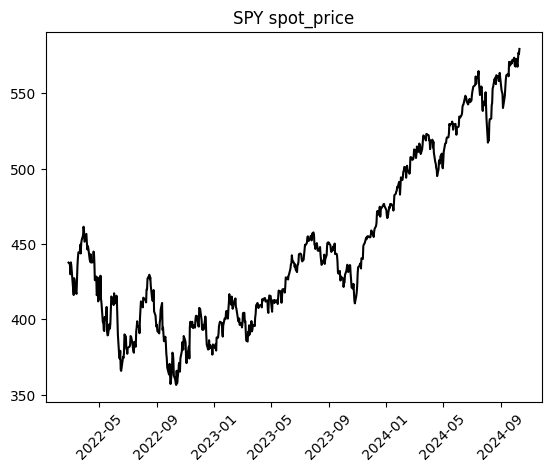

<Figure size 640x480 with 0 Axes>

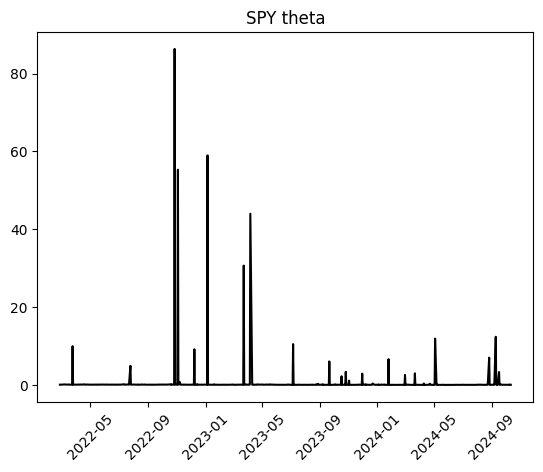

<Figure size 640x480 with 0 Axes>

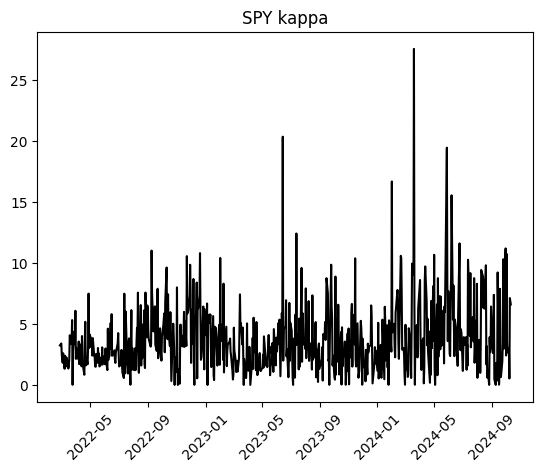

<Figure size 640x480 with 0 Axes>

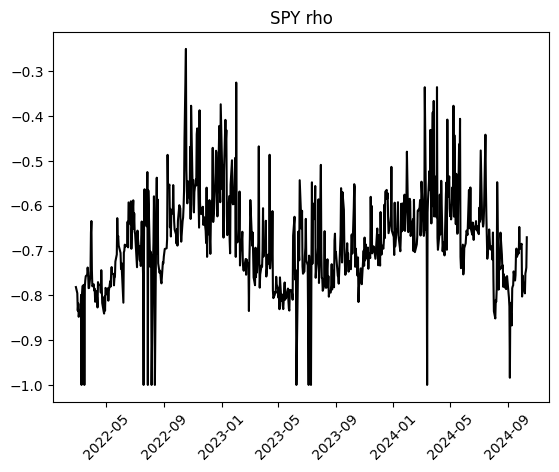

<Figure size 640x480 with 0 Axes>

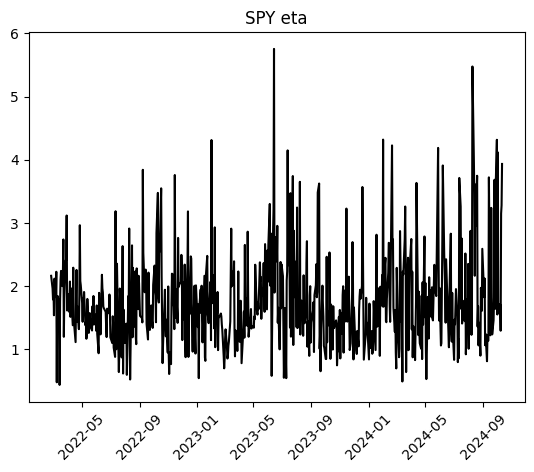

<Figure size 640x480 with 0 Axes>

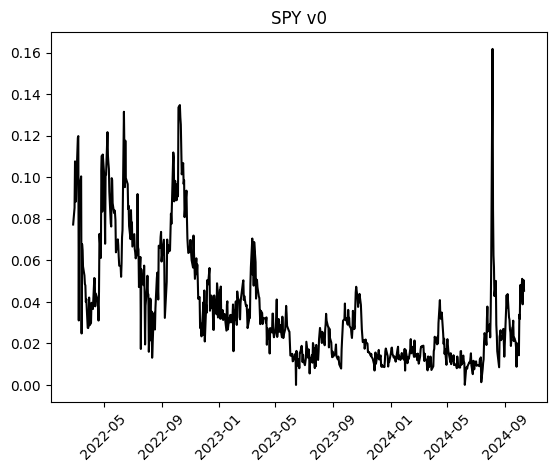


                    calculation_date   strike_price   market_price  \
count                        1551806 1551806.000000 1551806.000000   
mean   2023-06-17 06:26:52.880992768     430.116245      36.800414   
min              2022-02-25 00:00:00      85.000000       0.000000   
25%              2022-10-05 00:00:00     360.000000       0.350000   
50%              2023-06-13 00:00:00     429.000000       7.420000   
75%              2024-03-01 00:00:00     500.000000      43.900000   
max              2024-10-11 00:00:00     830.000000     461.370000   
std                              NaN     116.162869      62.346871   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 1551806.000000    1551806.000000 1551806.000000  1551806.000000   
mean        0.251238        106.687002     450.199414        0.040000   
min         0.006110         30.000000     356.560000        0.040000   
25%         0.154280         50.000000     401.440000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [6]:
calibration_keys = keys_df.copy().dropna(subset='calibration_key')
calibrations = []
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True)
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date')
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()
for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

# computed prices

# data cleaning

## idendifying calibration errors